In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.spatial import distance
import warnings
warnings.simplefilter('ignore')
import time
import datetime

from IPython.display import clear_output, Image
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix 
from tqdm import tqdm, tqdm_notebook, trange

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KDTree, DistanceMetric
from sklearn.metrics import accuracy_score

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [307]:
#train_full = pd.read_csv("MNIST_train.csv")

colnames = ["dig"] + [i for i in range(1, 28*28+1)]
train = pd.read_csv("MNIST_train_small.csv", names=colnames)
test = pd.read_csv("MNIST_test_small.csv", names=colnames)

In [308]:
train.head()

,dig,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [322]:
train.shape, test.shape

((3000, 785), (1000, 785))

Implementation with a KDTree

In [365]:
def predict_with_KDtree(train_data, test_data, k, p):

    tree = KDTree(train_data[:,1:], metric=DistanceMetric.get_metric("minkowski", p=p))
    actual = []
    predictions = []
    
    for test_digit in test_data:
        _, ind = tree.query(test_digit[1:].reshape(1, -1), k=k)
        neighboring_digits = [dig[0] for dig in train.values[ind][0]]
        predicted_digit = pd.value_counts(neighboring_digits).sort_values(ascending=False).index[0]
        
        actual.append(test_digit[0])
        predictions.append(predicted_digit)

    return actual, predictions

In [330]:
# act, preds = predict_with_KDtree(train.values, test.values, 10, 2)

In [333]:
ks = range(1, 21)
accs = []

for k in tqdm(ks):
    act, preds = predict_with_KDtree(train.values, test.values, k, 2)
    accs.append(accuracy_score(act, preds))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.43s/it]


The best accuracy (0.924) on the TEST set is achieved with k = 4 


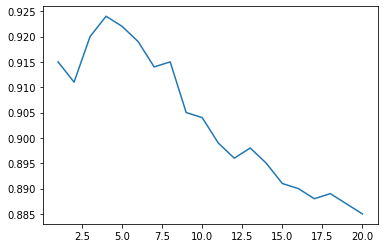

In [340]:
plt.plot(ks, accs);
print(f"The best accuracy ({max(accs)}) on the TEST set is achieved with k = {ks[np.argmax(accs)]} ")

Leave-One-Out Cross-Validation

In [376]:
p = 2 # euclidean distance
tree = KDTree(train.values[:,1:], metric=DistanceMetric.get_metric("minkowski", p=p))

# for each k
ks = [1,]#range(1, 21)
accs = []

for k in tqdm(ks):
    for digit in tqdm_notebook(train.values):
        _, ind = tree.query(digit[1:].reshape(1, -1), k=k+1)
        neighboring_digits = [dig[0] for dig in train.values[ind][0]]
        neighboring_digits = neighboring_digits[1:] # not including the digit itself
        predicted_digit = pd.value_counts(neighboring_digits).sort_values(ascending=False).index[0]

        actual.append(test_digit[0])
        predictions.append(predicted_digit)

    accs.append(accuracy_score(actual, predictions))



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.74s/it]

In [377]:
accs

[0.1283872173425528]

# -------------------------